In [5]:
import xml.etree.ElementTree as ET
import cv2
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from xml.etree.ElementTree import parse
from PIL import Image, ImageDraw
from glob import glob
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Activation, BatchNormalization, Add, Multiply
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import torch
# from ultralytics import YOLO

In [6]:
def visualize_annotations(image_path, xml_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    tree = ET.parse(xml_path)
    root = tree.getroot()

    for obj in root.findall('object'):
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)

        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color=(255, 0, 0), thickness=2)

        polygon = obj.find('polygon')
        if polygon is not None:
            points = []
            for i in range(1, len(polygon)//2 + 1):
                x = int(polygon.find(f'x{i}').text)
                y = int(polygon.find(f'y{i}').text)
                points.append((x, y))
            points = np.array(points, np.int32)
            points = points.reshape((-1, 1, 2))
            cv2.polylines(image, [points], isClosed=True, color=(0, 255, 0), thickness=2)

    return image

In [7]:
def visualize_sample_images(image_paths, xml_paths, num_samples=5):
    plt.figure(figsize=(50, 50))

    for i in range(num_samples):
        image = visualize_annotations(image_paths[i], xml_paths[i])

        plt.subplot(1, num_samples, i + 1)
        plt.imshow(image)
        plt.axis('off')
        plt.title(f'Sample {i+1}')

    plt.show()

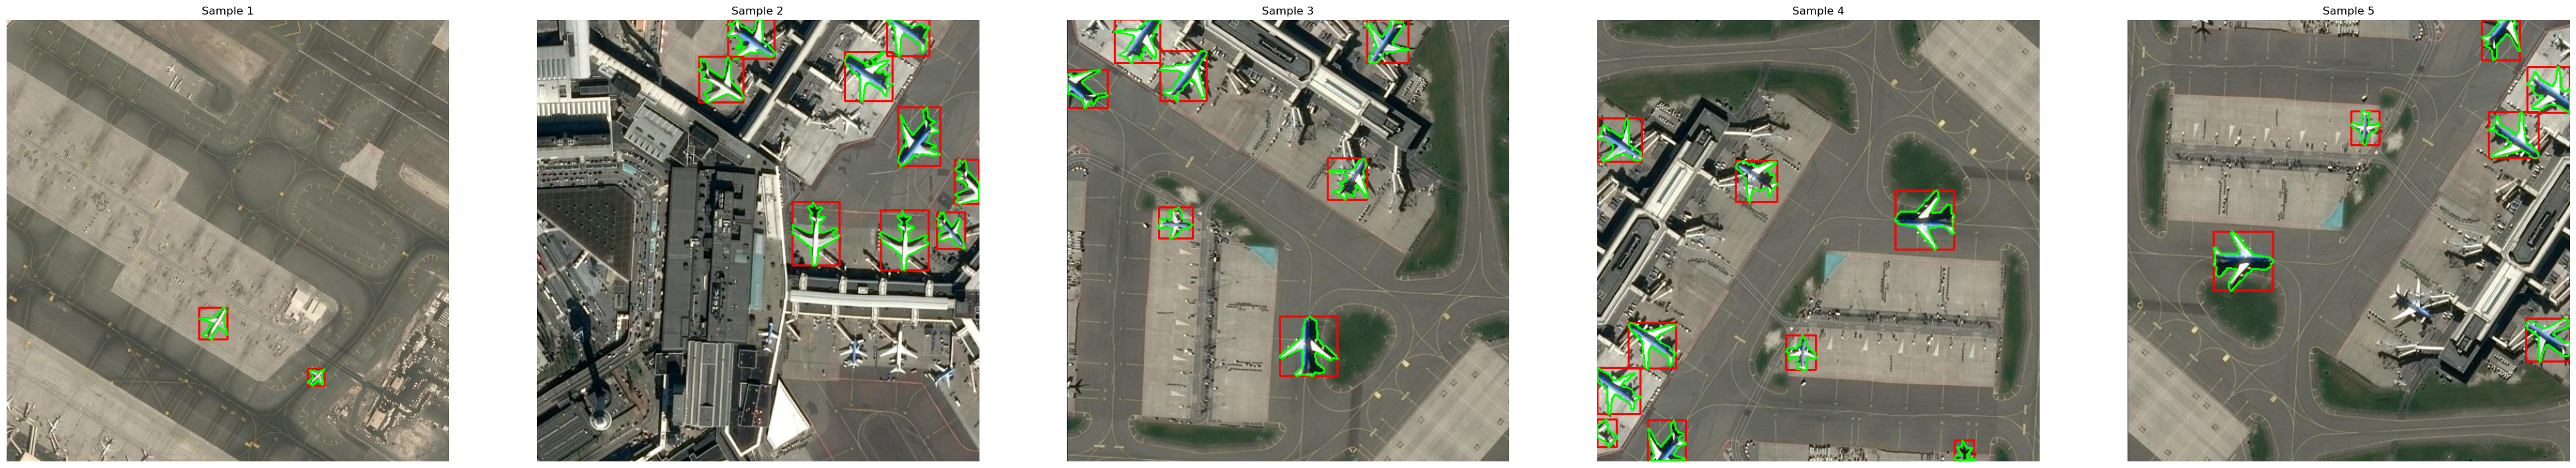

In [8]:
image_paths = ["MiniProjectData/Final Semantic Data/001.jpg", "MiniProjectData/Final Semantic Data/002.jpg", "MiniProjectData/Final Semantic Data/003.jpg", "MiniProjectData/Final Semantic Data/004.jpg", "MiniProjectData/Final Semantic Data/005.jpg"]
xml_paths = ["MiniProjectData/FinalSegementationData/001.xml", "MiniProjectData/FinalSegementationData/002.xml", "MiniProjectData/FinalSegementationData/003.xml", "MiniProjectData/FinalSegementationData/004.xml", "MiniProjectData/FinalSegementationData/005.xml"]
visualize_sample_images(image_paths, xml_paths)

image_path = "3e321b8a-9504-45aa-82b4-16158e28e290_0_0_jpg.rf.f11dfad28bd1053f969d13e0b1d0596c.jpg"

In [9]:
def parse_polygon_from_xml(xml_path, image_shape):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    mask = np.zeros(image_shape[:2], dtype=np.uint8)
    
    for obj in root.findall('object'):
        polygon = obj.find('polygon')
        points = []
        for i in range(1, len(polygon) // 2 + 1):
            x = int(polygon.find(f'x{i}').text)
            y = int(polygon.find(f'y{i}').text)
            points.append((x, y))
        
        # Convert points to a NumPy array and draw polygon on mask
        points = np.array(points, np.int32)
        cv2.fillPoly(mask, [points], color=1)
    
    return mask

In [10]:
def parse_xml(xml_path):
    tree = parse(xml_path)
    root = tree.getroot()

    objects = []
    for obj in root.findall('object'):
        bndbox = obj.find('bndbox')
        polygon = obj.find('polygon')

        # Get bounding box
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)

        # Get polygon points
        points = []
        for i in range(1, 18):  # Assuming polygons have 17 points as in your example
            x_tag = f'x{i}'
            y_tag = f'y{i}'
            x = polygon.find(x_tag)
            y = polygon.find(y_tag)
            if x is not None and y is not None:
                points.append((int(x.text), int(y.text)))

        objects.append({'bndbox': (xmin, ymin, xmax, ymax), 'polygon': points})
    return objects

In [11]:
def create_mask(image_size, objects, original_size=(640, 640)):
    mask = Image.new('L', image_size, 0)  # Grayscale mask (1 channel)
    draw = ImageDraw.Draw(mask)
    scale_x = image_size[0] / original_size[0]
    scale_y = image_size[1] / original_size[1]

    for obj in objects:
        # Scale polygon points to fit within the target mask size
        scaled_polygon = [(int(x * scale_x), int(y * scale_y)) for x, y in obj['polygon']]
        print("Drawing scaled polygon:", scaled_polygon)  # Debug: Print scaled polygon

        if scaled_polygon:
            draw.polygon(scaled_polygon, outline=1, fill=1)  # Draw the scaled polygon

    mask_array = np.array(mask)
    print("Unique values in generated mask after scaling:", np.unique(mask_array))  # Check for 1s
    return mask_array

In [12]:
def load_data(image_dir, xml_dir, input_size):
    image_files = sorted(glob(os.path.join(image_dir, '*.jpg')))
    xml_files = sorted(glob(os.path.join(xml_dir, '*.xml')))

    images, masks = [], []

    for img_path, xml_path in zip(image_files, xml_files):
        # Load and resize image
        img = load_img(img_path, target_size=input_size)
        img = img_to_array(img) / 255.0  # Normalize image

        # Parse XML to create mask
        objects = parse_xml(xml_path)
        mask = create_mask(input_size, objects)  # Generate mask based on XML annotations
        mask = np.expand_dims(mask, axis=-1)  # Add channel dimension

        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)

In [13]:
def predict_mask(model, image_path, input_size=(256, 256), threshold=0.5):

    # Load and preprocess the image
    original_image = load_img(image_path)  # Load original image for reference
    image = load_img(image_path, target_size=input_size)  # Load and resize for model input
    image = img_to_array(image) / 255.0  # Normalize to [0, 1]
    image = np.expand_dims(image, axis=0)  # Add batch dimension

    # Predict the mask
    predicted_mask = model.predict(image)[0]  # Predict mask for the single image

    # Apply threshold to create binary mask
    predicted_mask = (predicted_mask > threshold).astype(np.uint8)

    # Resize predicted mask back to original image size if needed
    predicted_mask_resized = np.squeeze(predicted_mask)  # Remove single channel if needed

    return original_image, predicted_mask_resized

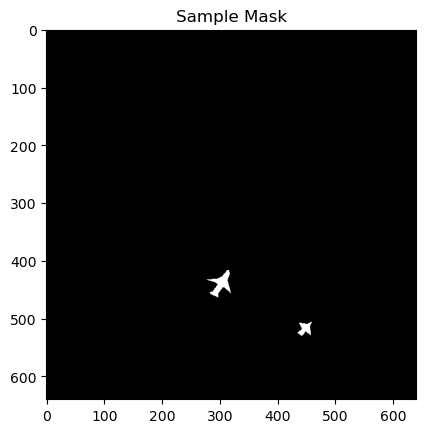

In [59]:
# Get a sample mask
sample_mask = parse_polygon_from_xml(xml_paths[0], cv2.imread(image_paths[0]).shape)
   # Display the mask to check if it's not entirely black
plt.imshow(sample_mask, cmap='gray')
plt.title("Sample Mask")
plt.show()

In [14]:
def plot_training_history(history):
    # Extract accuracy and loss values for both training and validation sets
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(accuracy) + 1)

    # Plot Training and Validation Accuracy
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Training and Validation Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

['MiniProjectData/Final Semantic Data/001.jpg', 'MiniProjectData/Final Semantic Data/002.jpg', 'MiniProjectData/Final Semantic Data/003.jpg', 'MiniProjectData/Final Semantic Data/004.jpg', 'MiniProjectData/Final Semantic Data/005.jpg']
['MiniProjectData/FinalSegementationData/001.xml', 'MiniProjectData/FinalSegementationData/002.xml', 'MiniProjectData/FinalSegementationData/003.xml', 'MiniProjectData/FinalSegementationData/004.xml', 'MiniProjectData/FinalSegementationData/005.xml']


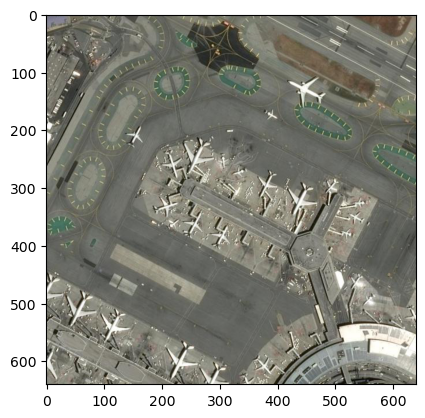

In [15]:
# Print the paths
print(image_paths)
print(xml_paths)

# Display a sample image
img = mpimg.imread(image_path)
imgplot = plt.imshow(img)
plt.show()

In [16]:
image_dir = 'MiniProjectData/Final Semantic Data'
xml_dir = 'MiniProjectData/FinalSegementationData'
input_size = (256, 256)  # Resize images and masks to 256x256

In [17]:
# Load data
images, masks = load_data(image_dir, xml_dir, input_size)
print(f"Loaded {len(images)} images and {len(masks)} masks.")

Drawing scaled polygon: [(126, 166), (125, 166), (121, 171), (118, 172), (111, 173), (116, 174), (118, 176), (115, 181), (113, 182), (114, 183), (118, 185), (118, 182), (122, 178), (123, 178), (127, 182), (125, 173), (126, 169)]
Drawing scaled polygon: [(183, 202), (180, 204), (175, 203), (177, 207), (174, 210), (176, 212), (179, 208), (182, 211), (182, 205)]
Unique values in generated mask after scaling: [0 1]
Drawing scaled polygon: [(225, 50), (223, 52), (224, 59), (217, 66), (214, 62), (210, 55), (210, 56), (211, 60), (211, 63), (213, 69), (213, 72), (210, 75), (209, 79), (208, 82), (210, 84), (215, 82), (218, 78)]
Drawing scaled polygon: [(110, 2), (110, 3), (112, 2), (113, 3), (113, 5), (110, 8), (110, 9), (115, 9), (118, 12), (118, 13), (114, 16), (116, 16), (118, 15), (120, 15), (118, 18), (113, 21), (113, 22)]
Drawing scaled polygon: [(110, 21), (109, 22), (108, 31), (107, 33), (99, 28), (97, 23), (96, 24), (94, 22), (94, 22), (95, 27), (93, 29), (93, 30), (95, 30), (96, 31), 

Unique values in generated mask after scaling: [0 1]
Drawing scaled polygon: [(113, 115), (112, 115), (112, 119), (111, 120), (109, 120), (105, 118), (104, 119), (105, 124), (109, 125), (110, 128), (116, 124), (121, 123), (118, 120), (116, 120), (114, 119)]
Drawing scaled polygon: [(92, 135), (90, 136), (90, 140), (84, 145), (85, 146), (89, 146), (89, 150), (90, 151), (94, 150), (95, 146), (97, 144), (99, 144), (94, 140)]
Drawing scaled polygon: [(161, 80), (160, 80), (160, 82), (157, 86), (154, 83), (153, 83), (153, 84), (155, 88), (154, 90), (156, 94), (159, 94), (162, 91), (166, 90), (166, 90), (162, 89), (162, 88), (162, 85)]
Drawing scaled polygon: [(124, 86), (122, 87), (122, 88), (124, 91), (124, 92), (125, 94), (124, 95), (121, 96), (122, 97), (125, 97), (127, 99), (130, 104), (132, 105), (132, 100), (131, 96), (133, 92), (134, 91)]
Drawing scaled polygon: [(121, 149), (121, 154), (118, 155), (114, 154), (114, 159), (120, 158), (121, 159), (121, 163), (124, 160), (127, 158), (1

In [64]:
def unet_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)

    # Decoder
    u4 = UpSampling2D((2, 2))(c3)
    u4 = concatenate([u4, c2])
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(u4)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(c4)

    u5 = UpSampling2D((2, 2))(c4)
    u5 = concatenate([u5, c1])
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(u5)
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(c5)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5)
    model = Model(inputs=[inputs], outputs=[outputs])

    return model

In [66]:
# Build U-Net model
U_model = unet_model()
U_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
U_model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_53 (Conv2D)  │ (None, 256, 256,  │      1,792 │ input_layer_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_54 (Conv2D)  │ (None, 256, 256,  │     36,928 │ conv2d_53[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 128, 128,  │          0 │ conv2d_54[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_55 (Conv2D)  │ (None, 128, 128,  │     73,856 │ max_pooling2d_8[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_56 (Conv2D)  │ (None, 128, 128,  │    147,584 │ conv2d_55[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 64, 64,    │          0 │ conv2d_56[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_57 (Conv2D)  │ (None, 64, 64,    │    295,168 │ max_pooling2d_9[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_58 (Conv2D)  │ (None, 64, 64,    │    590,080 │ conv2d_57[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_8     │ (None, 128, 128,  │          0 │ conv2d_58[0][0]   │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 128, 128,  │          0 │ up_sampling2d_8[… │
│ (Concatenate)       │ 384)              │            │ conv2d_56[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_59 (Conv2D)  │ (None, 128, 128,  │    442,496 │ concatenate_8[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 128, 128,  │    147,584 │ conv2d_59[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_9     │ (None, 256, 256,  │          0 │ conv2d_60[0][0]   │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 256, 256,  │          0 │ up_sampling2d_9[… │
│ (Concatenate)       │ 192)              │            │ conv2d_54[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_61 (Conv2D)  │ (None, 256, 256,  │    110,656 │ concatenate_9[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_62 (Conv2D)  │ (None, 256, 256,  │     36,928 │ conv2d_61[0][0] 

 Total params: 1,883,137 (7.18 MB)

 Trainable params: 1,883,137 (7.18 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

In [68]:
# Train the model
history = U_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=8,
    epochs=50,
    verbose=1
)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step - accuracy: 0.9868 - loss: 0.4085 - val_accuracy: 0.9889 - val_loss: 0.0878
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.9866 - loss: 0.0989 - val_accuracy: 0.9889 - val_loss: 0.0869
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.9891 - loss: 0.0874 - val_accuracy: 0.9889 - val_loss: 0.0862
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.9873 - loss: 0.0902 - val_accuracy: 0.9889 - val_loss: 0.0793
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.9893 - loss: 0.0759 - val_accuracy: 0.9889 - val_loss: 0.0802
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.9883 - loss: 0.0786 - val_accuracy: 0.9889 - val_loss: 0.0708
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.9878 - loss: 0.0741 - val_accuracy: 0.9889 - val_loss: 0.0685
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.9858 - loss: 0.0828 - val_accuracy: 0.9889 - val_loss: 0.0733
Epoch 9/

In [78]:
# Select a sample image and mask from the validation set
sample_image = X_val[0]
sample_mask = y_val[0]

# Predict the mask
predicted_mask = U_model.predict(np.expand_dims(sample_image, axis=0))[0]
predicted_mask = (predicted_mask > 0.1).astype(np.uint8)  # Threshold to create binary mask

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


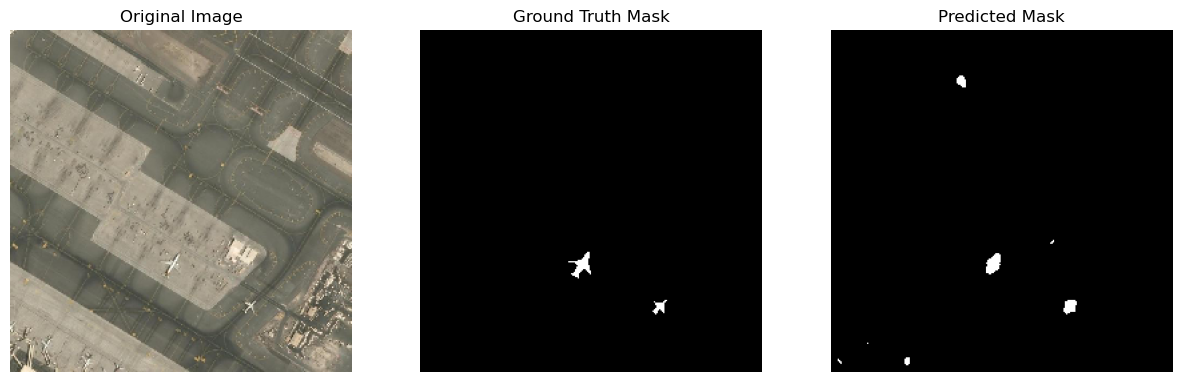

In [74]:
# Visualize the original image, ground truth, and predicted mask
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(sample_image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(sample_mask.squeeze(), cmap='gray')
plt.title("Ground Truth Mask")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(predicted_mask.squeeze(), cmap='gray')
plt.title("Predicted Mask")
plt.axis("off")

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


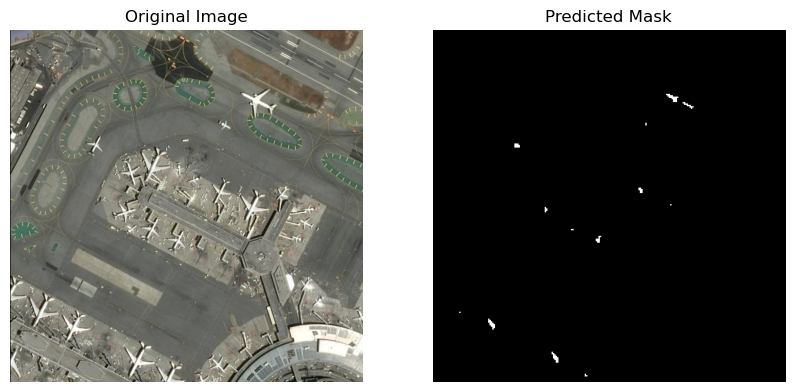

In [79]:
# Example usage with visualization
original_image, predicted_mask = predict_mask(U_model, image_path)

# Plot the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(predicted_mask, cmap='gray')
plt.title("Predicted Mask")
plt.axis("off")

plt.show()

In [80]:
# Predict without thresholding and inspect values
raw_predicted_mask = U_model.predict(np.expand_dims(sample_image, axis=0))[0]
print("Predicted mask values (before thresholding):", raw_predicted_mask)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
Predicted mask values (before thresholding): [[[0.11223263]
  [0.07055188]
  [0.05498188]
  ...
  [0.00315957]
  [0.00434774]
  [0.01583272]]

 [[0.06666433]
  [0.04354265]
  [0.03560284]
  ...
  [0.00046023]
  [0.00057356]
  [0.00250623]]

 [[0.05716289]
  [0.04429341]
  [0.03984386]
  ...
  [0.00028497]
  [0.00024776]
  [0.00084504]]

 ...

 [[0.01006511]
  [0.00393382]
  [0.00395029]
  ...
  [0.0046389 ]
  [0.00420089]
  [0.01153273]]

 [[0.01453172]
  [0.00472185]
  [0.00394182]
  ...
  [0.00566112]
  [0.00588132]
  [0.01775897]]

 [[0.04269422]
  [0.01200602]
  [0.00832073]
  ...
  [0.01172851]
  [0.01453535]
  [0.04457636]]]


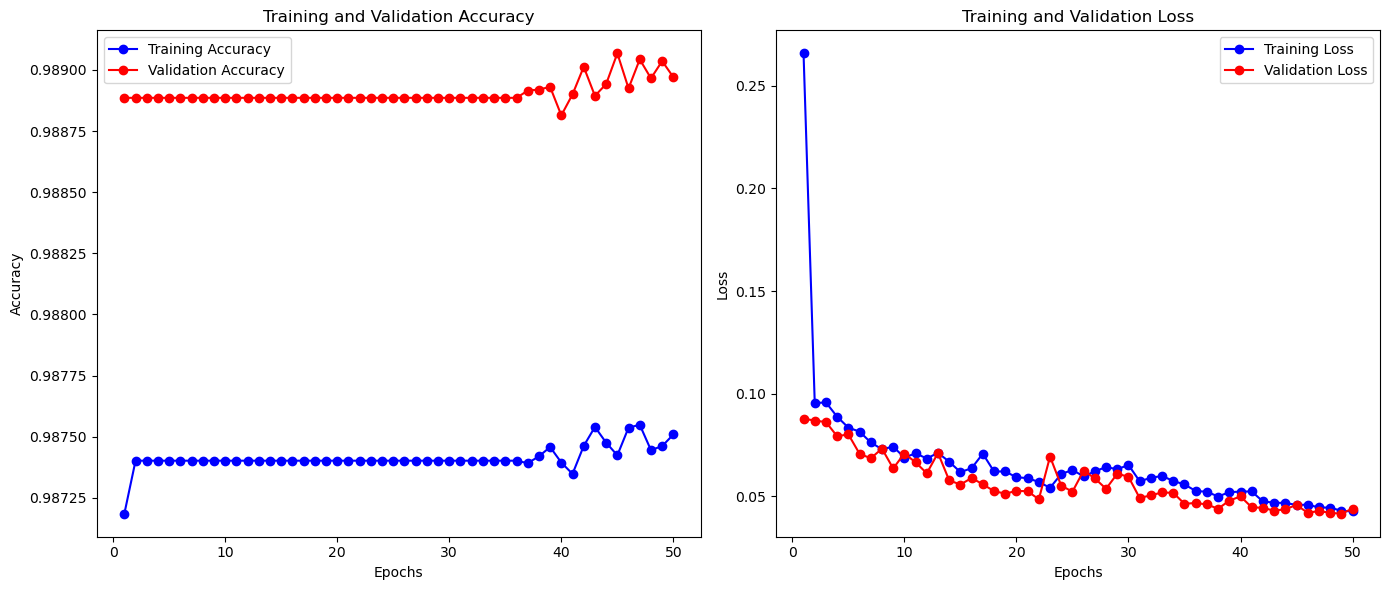

In [81]:
# Call the function with the training history
plot_training_history(history)

In [19]:
# Define an Attention Block
def attention_block(x, g, inter_channel):
    theta_x = Conv2D(inter_channel, kernel_size=1, strides=1, padding='same')(x)
    phi_g = Conv2D(inter_channel, kernel_size=1, strides=1, padding='same')(g)
    add_xg = Add()([theta_x, phi_g])
    relu_xg = Activation('relu')(add_xg)
    psi = Conv2D(1, kernel_size=1, strides=1, padding='same')(relu_xg)
    sigmoid_xg = Activation('sigmoid')(psi)
    attn_output = Multiply()([x, sigmoid_xg])
    return attn_output

In [20]:
# Define Attention U-Net Model
def attention_unet(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    
    # Encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    # Bottleneck
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)
    
    # Decoder with Attention Gates
    up6 = UpSampling2D(size=(2, 2))(conv5)
    attn6 = attention_block(conv4, up6, 512)  # Attention gate on skip connection
    merge6 = concatenate([up6, attn6], axis=3)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)
    
    up7 = UpSampling2D(size=(2, 2))(conv6)
    attn7 = attention_block(conv3, up7, 256)
    merge7 = concatenate([up7, attn7], axis=3)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)
    
    up8 = UpSampling2D(size=(2, 2))(conv7)
    attn8 = attention_block(conv2, up8, 128)
    merge8 = concatenate([up8, attn8], axis=3)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)
    
    up9 = UpSampling2D(size=(2, 2))(conv8)
    attn9 = attention_block(conv1, up9, 64)
    merge9 = concatenate([up9, attn9], axis=3)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv9)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [84]:
# Instantiate the model
AU_model = attention_unet()
AU_model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_64 (Conv2D)  │ (None, 256, 256,  │      1,792 │ input_layer_4[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_65 (Conv2D)  │ (None, 256, 256,  │     36,928 │ conv2d_64[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 128, 128,  │          0 │ conv2d_65[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_66 (Conv2D)  │ (None, 128, 128,  │     73,856 │ max_pooling2d_10… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_67 (Conv2D)  │ (None, 128, 128,  │    147,584 │ conv2d_66[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 64, 64,    │          0 │ conv2d_67[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_68 (Conv2D)  │ (None, 64, 64,    │    295,168 │ max_pooling2d_11… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_69 (Conv2D)  │ (None, 64, 64,    │    590,080 │ conv2d_68[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 32, 32,    │          0 │ conv2d_69[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_70 (Conv2D)  │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_12… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_71 (Conv2D)  │ (None, 32, 32,    │  2,359,808 │ conv2d_70[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 16, 16,    │          0 │ conv2d_71[0][0]   │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_72 (Conv2D)  │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_13… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_73 (Conv2D)  │ (None, 16, 16,    │  9,438,208 │ conv2d_72[0][0]   │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_10    │ (None, 32, 32,    │          0 │ conv2d_73[0][0]   │
│ (UpSampling2D)      │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_74 (Conv2D)  │ (None, 32, 32,    │    262,656 │ conv2d_71[0][0] 

 Total params: 32,426,309 (123.70 MB)

 Trainable params: 32,426,309 (123.70 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Assuming `images` and `masks` are numpy arrays with loaded data
# Split data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

In [22]:
# Define ImageDataGenerator for augmentation
image_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

mask_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [23]:
# Define a custom generator to apply the same augmentation to images and masks
def train_generator(image_data, mask_data, batch_size):
    image_gen = image_datagen.flow(image_data, batch_size=batch_size, seed=42)
    mask_gen = mask_datagen.flow(mask_data, batch_size=batch_size, seed=42)
    while True:
        images = next(image_gen)  
        masks = next(mask_gen)  
        yield images, masks

In [88]:
# Create training generator
train_gen = train_generator(X_train, Y_train, batch_size=2)

# Example of using the generator in model.fit
AU_model.fit(train_gen, steps_per_epoch=len(X_train) // 2, epochs=20, validation_data=(X_val, Y_val))

Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.9829 - loss: 2.0316 - val_accuracy: 0.9889 - val_loss: 0.0800
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9862 - loss: 0.0714 - val_accuracy: 0.9889 - val_loss: 0.0857
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9846 - loss: 0.0965 - val_accuracy: 0.9889 - val_loss: 0.0852
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9815 - loss: 0.0971 - val_accuracy: 0.9889 - val_loss: 0.0802
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9874 - loss: 0.0602 - val_accuracy: 0.9889 - val_loss: 0.0646
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.9841 - loss: 0.0703 - val_accuracy: 0.9889 - val_loss: 0.0607
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9865 - loss: 0.0631 - val_accuracy: 0.9889 - val_loss: 0.0599
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9845 - loss: 0.0705 - val_accuracy: 0.9889 - val_loss:

In [26]:
# Evaluate the fine-tuned model on the validation set
val_loss, val_accuracy = AU_model.evaluate(X_val, Y_val)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.9805 - loss: 0.6893
Validation Loss: 0.6893
Validation Accuracy: 0.9805


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9805 - loss: 0.6893
Validation Loss: 0.6893011927604675, Validation Accuracy: 0.9804969429969788
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step


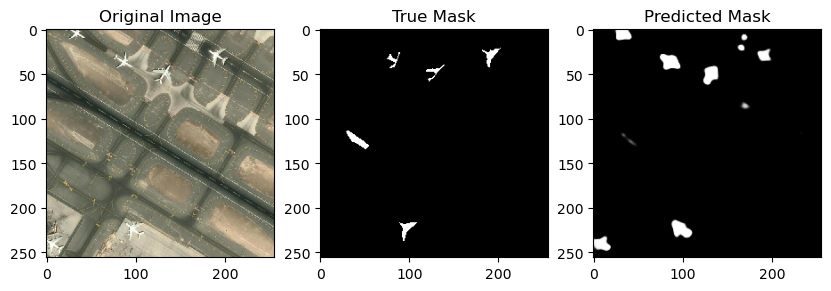

In [27]:
# Evaluate the model
loss, accuracy = AU_model.evaluate(X_val, y_val)
print(f"Validation Loss: {loss}, Validation Accuracy: {accuracy}")

# Predict on a sample image
sample_image = X_val[9]
predicted_mask = AU_model.predict(np.expand_dims(sample_image, axis=0))[0]

# Display the results

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(sample_image)

plt.subplot(1, 3, 2)
plt.title("True Mask")
plt.imshow(y_val[9].squeeze(), cmap="gray")

plt.subplot(1, 3, 3)
plt.title("Predicted Mask")
plt.imshow(predicted_mask.squeeze(), cmap="gray")

plt.show()

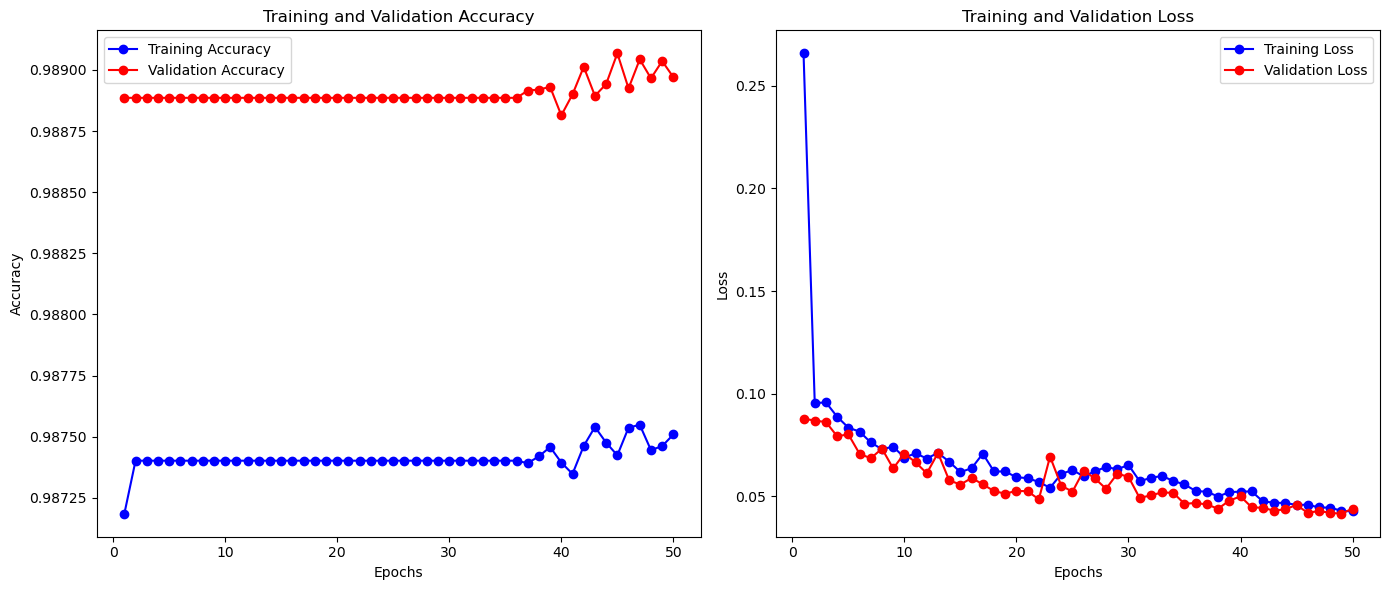

In [91]:
# Call the function with the training history
plot_training_history(history)

In [92]:
# Predict without thresholding and inspect values
raw_predicted_mask = AU_model.predict(np.expand_dims(sample_image, axis=0))[0]
print("Predicted mask values (before thresholding):", raw_predicted_mask)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
Predicted mask values (before thresholding): [[[0.09366736]
  [0.06168505]
  [0.04937639]
  ...
  [0.03256213]
  [0.04492479]
  [0.10149775]]

 [[0.07166559]
  [0.04770612]
  [0.03686828]
  ...
  [0.02336074]
  [0.02691433]
  [0.05325894]]

 [[0.06150141]
  [0.04195452]
  [0.03052627]
  ...
  [0.01823557]
  [0.01935956]
  [0.03592968]]

 ...

 [[0.06661688]
  [0.04572141]
  [0.04299879]
  ...
  [0.01390618]
  [0.01392841]
  [0.02717679]]

 [[0.06552206]
  [0.03738543]
  [0.03412768]
  ...
  [0.01540136]
  [0.01902757]
  [0.04030249]]

 [[0.10768225]
  [0.05116925]
  [0.04050005]
  ...
  [0.01907575]
  [0.02747237]
  [0.06107157]]]


In [93]:
# Unfreeze the last 10 layers of the base model for fine-tuning
for layer in AU_model.layers[-10:]:
    layer.trainable = True

In [104]:
# predicted_mask = (raw_predicted_mask > 0.4).astype(np.uint8)

In [3]:
def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return 1 - (numerator + tf.keras.backend.epsilon()) / (denominator + tf.keras.backend.epsilon())

AU_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=dice_loss, metrics=['accuracy'])

In [96]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

history = AU_model.fit(
    train_gen,
    steps_per_epoch=len(X_train) // 2,
    epochs=50,
    validation_data=(X_val, Y_val),
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.9867 - loss: 0.9635 - val_accuracy: 0.9889 - val_loss: 0.9513 - learning_rate: 1.0000e-04
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9813 - loss: 0.9408 - val_accuracy: 0.9889 - val_loss: 0.9257 - learning_rate: 1.0000e-04
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9826 - loss: 0.9300 - val_accuracy: 0.9889 - val_loss: 0.9042 - learning_rate: 1.0000e-04
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9889 - loss: 0.9215 - val_accuracy: 0.9889 - val_loss: 0.8975 - learning_rate: 1.0000e-04
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9872 - loss: 0.9232 - val_accuracy: 0.9889 - val_loss: 0.8880 - learning_rate: 1.0000e-04
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9814 - loss: 0.8990 - val_accuracy: 0.9886 - val_loss: 0.8595 - learning_rate: 1.0000e-04
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9742 - loss:

24/24 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9801 - loss: 0.7193 - val_accuracy: 0.9795 - val_loss: 0.6965 - learning_rate: 1.2500e-05
Epoch 45/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.9754 - loss: 0.7212 - val_accuracy: 0.9837 - val_loss: 0.7004 - learning_rate: 1.2500e-05
Epoch 46/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9773 - loss: 0.6783 - val_accuracy: 0.9805 - val_loss: 0.6893 - learning_rate: 1.2500e-05
Epoch 47/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9792 - loss: 0.6510 - val_accuracy: 0.9831 - val_loss: 0.6919 - learning_rate: 1.2500e-05
Epoch 48/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9819 - loss: 0.6806 - val_accuracy: 0.9796 - val_loss: 0.6909 - learning_rate: 1.2500e-05
Epoch 49/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9727 - loss: 0.6982 - val_accuracy: 0.9844 - val_loss: 0.7095 - learning_rate: 1.2500e-05
Epoch 50/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9783 - loss: 0.72

In [97]:
val_loss, val_accuracy = AU_model.evaluate(X_val, Y_val)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9805 - loss: 0.6893
Validation Loss: 0.6893
Validation Accuracy: 0.9805


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9805 - loss: 0.6893
Validation Loss: 0.6893011927604675, Validation Accuracy: 0.9804969429969788
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


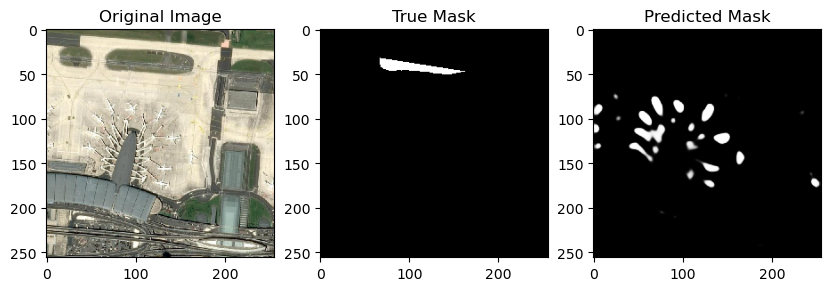

In [112]:
# Evaluate the model
loss, accuracy = AU_model.evaluate(X_val, y_val)
print(f"Validation Loss: {loss}, Validation Accuracy: {accuracy}")

# Predict on a sample image
sample_image = X_val[7]
predicted_mask = AU_model.predict(np.expand_dims(sample_image, axis=0))[0]

# Display the results

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(sample_image)

plt.subplot(1, 3, 2)
plt.title("True Mask")
plt.imshow(y_val[7].squeeze(), cmap="gray")

plt.subplot(1, 3, 3)
plt.title("Predicted Mask")
plt.imshow(predicted_mask.squeeze(), cmap="gray")

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


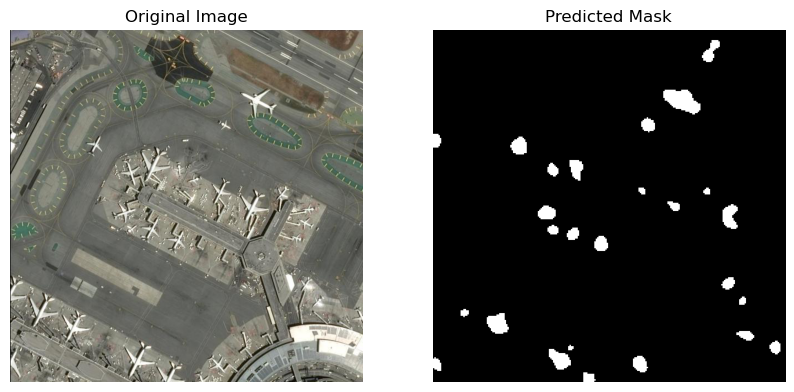

In [37]:
# Example usage with visualization
original_image, predicted_mask = predict_mask(AU_model, image_path, threshold=0.5)

# Plot the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(predicted_mask, cmap='gray')
plt.title("Predicted Mask")
plt.axis("off")

plt.show()

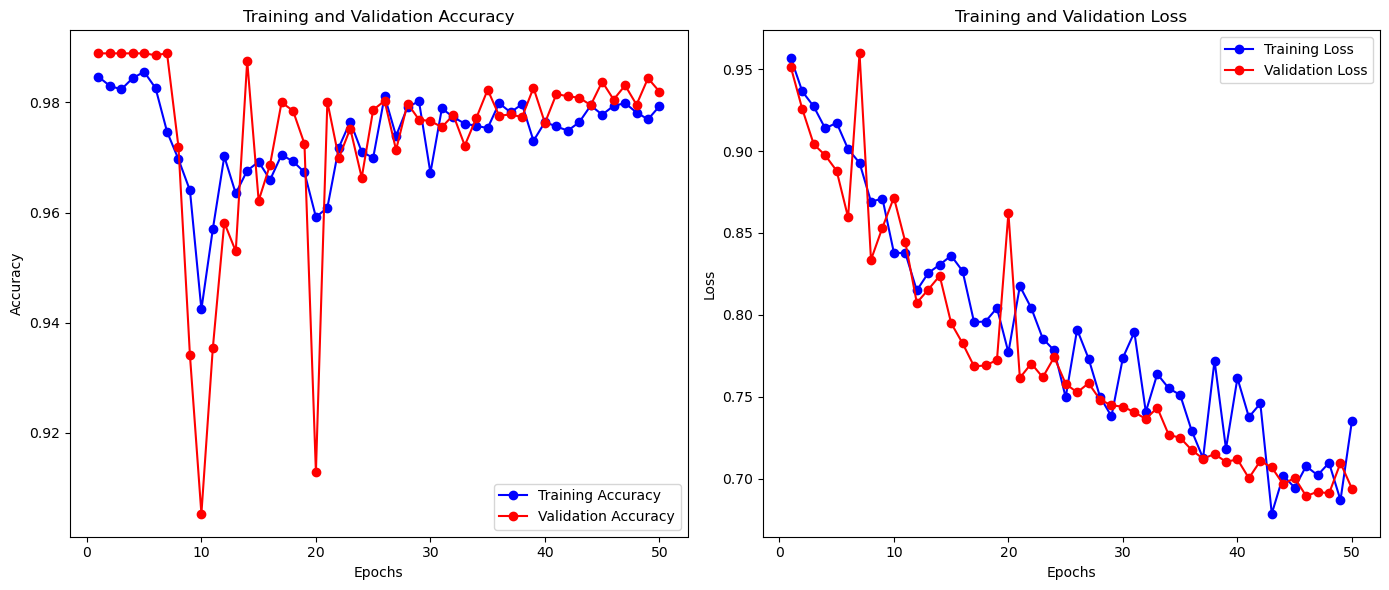

In [113]:
# Call the function with the training history
plot_training_history(history)

In [123]:
# Saving the model
AU_model.save('AU_model.h5')

In [25]:
# Loading the model
from tensorflow.keras.models import load_model
AU_model = load_model('AU_model.h5', custom_objects={'dice_loss': dice_loss})

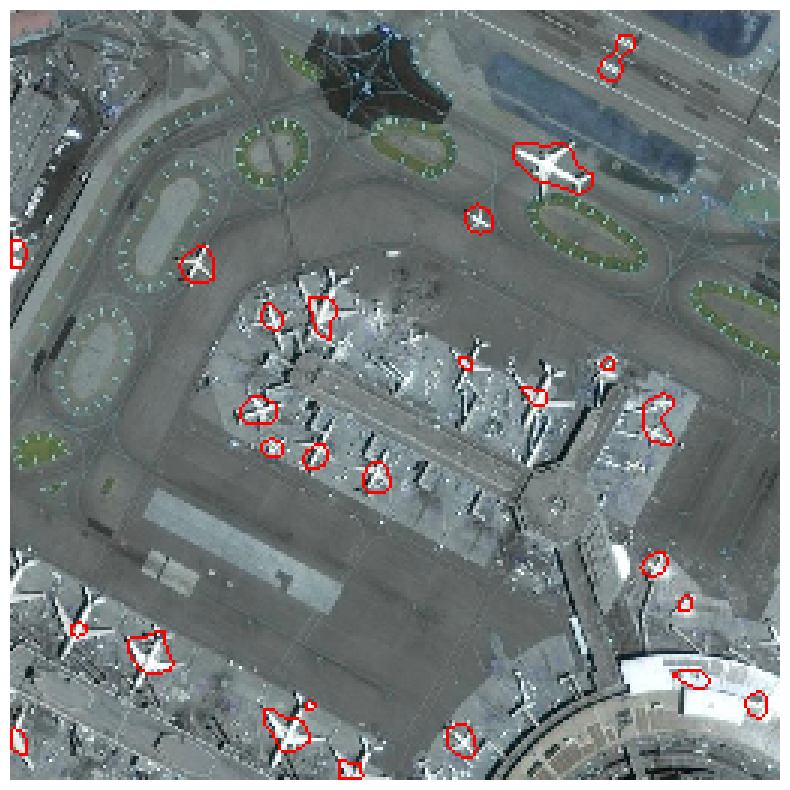

In [40]:
# Assuming `input_image` is your input image (loaded as a NumPy array)
# and `predicted_mask` is the binary mask (same height and width as input image)
input_image = load_img(image_path, target_size=input_size)
input_image = img_to_array(input_image)/255.0

# Convert predicted mask to 8-bit if needed
predicted_mask = (predicted_mask * 255).astype(np.uint8)

# Find contours in the predicted mask
contours, _ = cv2.findContours(predicted_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Convert the input image to BGR if it's grayscale (for color overlay)
if len(input_image.shape) == 2 or input_image.shape[2] == 1:
    input_image = cv2.cvtColor(input_image, cv2.COLOR_GRAY2BGR)

# Draw contours on the image in red color
cv2.drawContours(input_image, contours, -1, (0, 0, 255), thickness=1)  # Red color in BGR

# Display the result
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct display
plt.axis('off')
plt.show()

# FUTURE WORK

In [114]:
pip install ultralytics

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# XML-to-YOLO Conversion Function

def convert_xml_to_yolo(xml_dir, output_dir, image_dir, class_mapping):
    os.makedirs(output_dir, exist_ok=True)
    for xml_file in os.listdir(xml_dir):
        if not xml_file.endswith(".xml"):
            continue
        xml_path = os.path.join(xml_dir, xml_file)
        tree = ET.parse(xml_path)
        root = tree.getroot()
        size = root.find('size')
        img_width = int(size.find('width').text)
        img_height = int(size.find('height').text)
        txt_filename = os.path.splitext(xml_file)[0] + ".txt"
        txt_path = os.path.join(output_dir, txt_filename)
        
        with open(txt_path, "w") as f:
            for obj in root.findall('object'):
                class_name = obj.find('name').text
                if class_name not in class_mapping:
                    continue
                class_id = class_mapping[class_name]
                bndbox = obj.find('bndbox')
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)
                x_center = (xmin + xmax) / 2 / img_width
                y_center = (ymin + ymax) / 2 / img_height
                box_width = (xmax - xmin) / img_width
                box_height = (ymax - ymin) / img_height
                f.write(f"{class_id} {x_center} {y_center} {box_width} {box_height}\n")